In [1]:
import os
print("Current directory:", os.getcwd())

Current directory: /Users/varshasharma/Desktop/qa-automated-retail-analysis/notebooks


In [2]:
os.chdir('..')  # move up one level to project root

In [3]:
import pandas as pd

df = pd.read_csv('data/retail_order.csv', parse_dates=['Order Date', 'Ship Date'])

# Find duplicates Order IDs

duplicates = df[df.duplicated(subset='Order ID', keep=False)]
print(duplicates[['Order ID', 'Order Date', 'Customer ID']])

            Order ID Order Date Customer ID
0     CA-2016-152156 2016-08-11    CG-12520
1     CA-2016-152156 2016-08-11    CG-12520
3     US-2015-108966 2015-11-10    SO-20335
4     US-2015-108966 2015-11-10    SO-20335
5     CA-2014-115812 2014-09-06    BH-11710
...              ...        ...         ...
9987  CA-2017-163629 2017-11-17    RA-19885
9988  CA-2017-163629 2017-11-17    RA-19885
9990  CA-2017-121258 2017-02-26    DB-13060
9991  CA-2017-121258 2017-02-26    DB-13060
9992  CA-2017-121258 2017-02-26    DB-13060

[7456 rows x 3 columns]


/var/folders/33/s1v3z17x5vs0mgg845k9r16r0000gp/T/ipykernel_80324/2324410516.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data/retail_order.csv', parse_dates=['Order Date', 'Ship Date'])
/var/folders/33/s1v3z17x5vs0mgg845k9r16r0000gp/T/ipykernel_80324/2324410516.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data/retail_order.csv', parse_dates=['Order Date', 'Ship Date'])


In [4]:
duplicates[['Order ID', 'Customer ID', 'Product ID', 'Quantity', 'Sales', 'Profit']]


,Order ID,Customer ID,Product ID,Quantity,Sales,Profit
0,CA-2016-152156,CG-12520,FUR-BO-10001798,2,261.96,41.91
1,CA-2016-152156,CG-12520,FUR-CH-10000454,3,731.94,219.58
3,US-2015-108966,SO-20335,FUR-TA-10000577,5,957.58,-383.03
4,US-2015-108966,SO-20335,OFF-ST-10000760,2,22.37,2.52
5,CA-2014-115812,BH-11710,FUR-FU-10001487,7,48.86,14.17
...,...,...,...,...,...,...
9987,CA-2017-163629,RA-19885,TEC-AC-10001539,1,79.99,28.80
9988,CA-2017-163629,RA-19885,TEC-PH-10004006,5,206.10,55.65
9990,CA-2017-121258,DB-13060,FUR-FU-10000747,2,91.96,15.63
9991,CA-2017-121258,DB-13060,TEC-PH-10003645,2,258.58,19.39


In [5]:
duplicates.to_csv('reports/duplicate_order_ids.csv', index=False)


In [6]:

import sys

# Force the absolute path to your actual src folder
sys.path.insert(0, '/Users/varshasharma/Desktop/qa-automated-retail-analysis/src')

print("sys.path[0] =", sys.path[0])





sys.path[0] = /Users/varshasharma/Desktop/qa-automated-retail-analysis/src


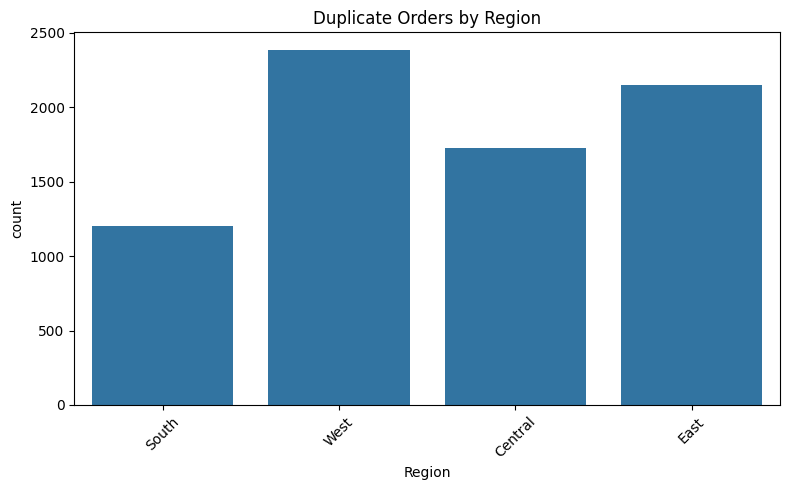

In [7]:
from visualize import plot_duplicate_orders_by_region

plot_duplicate_orders_by_region(duplicates)


Plot saved to ./reports/duplicate_orders_by_region.png


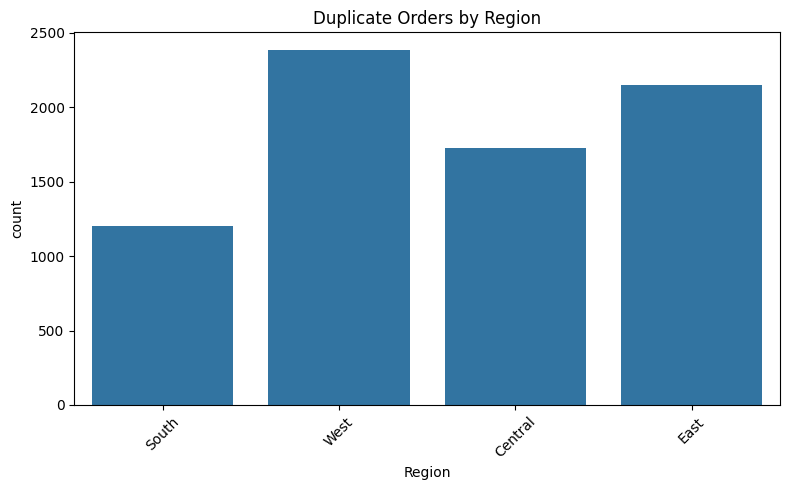

In [8]:
plot_duplicate_orders_by_region(duplicates, save_path='./reports/duplicate_orders_by_region.png')


In [9]:
# This works inside a notebook or script
duplicates.to_csv('./reports/duplicate_orders_log.csv', index=False)


## logging the output in the reports/log file

In [10]:
from validation import validate_no_nulls

nulls_df = validate_no_nulls(df)
nulls_df.to_csv('reports/null_issues_log.csv', index=False)



In [11]:
invalid_ship_dates = df[df['Ship Date'] < df['Order Date']]
invalid_ship_dates.to_csv('reports/ship_date_issues_log.csv', index=False)


## Exported Clean data to tableau folder

In [12]:
from validation import CRITICAL_COLUMNS

clean_df = df[
    (df['Ship Date'] >= df['Order Date']) &
    df['Order ID'].duplicated(keep=False) == False
]

clean_df = clean_df.dropna(subset=CRITICAL_COLUMNS)
clean_df.to_csv('tableau/clean_orders.csv', index=False)


In [13]:
clean_df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Retail Sales People', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Returned', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [14]:
import pandas as pd
from src.data_loader import load_orders
from src.validation import validate_order_ids_unique, validate_ship_after_order, validate_no_nulls

# Load the cleaned orders
df = load_orders()

# Run checks
order_id_check = validate_order_ids_unique(df)
ship_date_check = validate_ship_after_order(df)
nulls_df = validate_no_nulls(df)
null_check = nulls_df.empty

# Count duplicates
duplicates_count = df.duplicated(subset='Order ID').sum()



# Build the summary
qa_summary = pd.DataFrame([
    {
        "Rule": "Duplicate Order IDs",
        "Status": "Pass" if duplicates_count == 0 else "Fail",
        "Issues": duplicates_count
    },
    {
        "Rule": "Nulls in Critical Fields",
        "Status": "Pass" if null_check else "Fail",
        "Issues": 0 if null_check else nulls_df.shape[0]
    },
    {
        "Rule": "Ship Date After Order Date",
        "Status": "Pass" if ship_date_check else "Fail",
        "Issues": 0 if ship_date_check else (df["Ship Date"] < df["Order Date"]).sum()
    }
])

# Save to CSV for Tableau
qa_summary.to_csv("tableau/qa_summary.csv", index=False)

print("QA Summary saved to tableau/qa_summary.csv")


QA Summary saved to tableau/qa_summary.csv


/Users/varshasharma/Desktop/qa-automated-retail-analysis/src/data_loader.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, parse_dates=['Order Date', 'Ship Date'])
/Users/varshasharma/Desktop/qa-automated-retail-analysis/src/data_loader.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, parse_dates=['Order Date', 'Ship Date'])


In [18]:

#adding data dictionary for data governance 
import pandas as pd
import os

# Optional: create governance folder if not exists
os.makedirs("governance", exist_ok=True)

# Load your cleaned data
df = pd.read_csv("tableau/clean_orders.csv")

# Optional: Map known columns to descriptions
#description_map = {
    #"Order ID": "Unique identifier for each retail order",
    #"Order Date": "Date when the customer placed the order",
    #"Ship Date": "Date when the order was shipped",
    #"Customer ID": "Unique identifier for each customer",
    #"Customer Name": "Full name of the customer",
    #"Segment": "Customer segment (Consumer, Corporate, etc.)",
   #"Region": "Sales region of the customer",
    #"Returned": "Indicates whether the product was returned",
    #"Sales": "Total revenue for the order",
    #"Quantity": "Number of items ordered",
   # "Discount": "Discount applied to the order",
    #"Profit": "Net profit from the order",
    #"Product ID": "Unique identifier for each product",
    #"Product Name": "Name of the product",
    #"Category": "Top-level product category",
   # "Sub-Category": "More specific product category",
    #"Ship Mode": "Shipping method used for delivery",
    #"City": "City of delivery",
   # "State": "State of delivery",
   # "Postal Code": "Postal/ZIP code of the customer",
    #"Retail Sales People": "Salesperson responsible for the sale"
#}

# Auto-detect type and sample value
def classify_type(dtype):
    if pd.api.types.is_numeric_dtype(dtype):
        return "numeric"
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return "date"
    elif pd.api.types.is_bool_dtype(dtype):
        return "boolean"
    else:
        return "string"
# Generate data dictionary
data_dict = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": [df[col].dtype for col in df.columns],
    "Description": ["" for _ in df.columns],  # Leave blank to fill manually later
    "Example Value": [df[col].dropna().iloc[0] if not df[col].dropna().empty else "" for col in df.columns]
})

# Save the dictionary
data_dict.to_csv("governance/data_dictionary.csv", index=False)

print("Data dictionary saved to governance/data_dictionary.csv")


Data dictionary saved to governance/data_dictionary.csv


In [20]:
#logging steward_issues programmaticaly

import pandas as pd
import os

df = pd.read_csv("tableau/clean_orders.csv")
os.makedirs("governance", exist_ok=True)

issues = []

# Duplicate Order IDs
if not df['Order ID'].is_unique:
    issues.append({
        "Issue ID": "001",
        "Column": "Order ID",
        "Description": "Duplicate Order IDs detected",
        "Severity": "High",
        "Status": "Resolved",
        "Raised By": "QA Automation"
    })

# Ship Date before Order Date
if (df['Ship Date'] < df['Order Date']).any():
    issues.append({
        "Issue ID": "002",
        "Column": "Ship Date",
        "Description": "Ship Date occurs before Order Date",
        "Severity": "High",
        "Status": "Resolved",
        "Raised By": "QA Automation"
    })

# Sales outliers (e.g., > $10,000)
if (df['Sales'] > 10000).any():
    issues.append({
        "Issue ID": "003",
        "Column": "Sales",
        "Description": "Sales values exceed $10,000 (possible outliers)",
        "Severity": "Medium",
        "Status": "Open",
        "Raised By": "QA Automation"
    })

# Missing Return flags
if df['Returned'].isnull().any():
    issues.append({
        "Issue ID": "004",
        "Column": "Returned",
        "Description": "Missing return values in 'Returned' column",
        "Severity": "Low",
        "Status": "Open",
        "Raised By": "QA Automation"
    })

# Save
issues_df = pd.DataFrame(issues)
issues_df.to_csv("governance/steward_issues.csv", index=False)

print("🧾 Steward issue log saved to governance/steward_issues.csv")


🧾 Steward issue log saved to governance/steward_issues.csv
